In [1]:
# Import Libaries and Tools
import os
import sys
from astropy.io import fits
import sunpy.map
from aiapy.calibrate import register, update_pointing
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import glob

# ACWE utilities
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import ACWE Tools
sys.path.append(ROOT_DIR)
from ACWE_python_fall_2022 import acweSaveSeg_v4, acweRestoreScale
from DatasetTools import DataManagmentTools as dmt

In [2]:
# File
dataset = '/home/jgra/Coronal Holes/newDataset/'
ImageNames = ['CR2099/2010-07-25T120002Z/aia.lev1_euv_12s.2010-07-25T120009Z.193.image_lev1.fits',
              'CR2100/2010-08-21T220002Z/aia.lev1_euv_12s.2010-08-21T220009Z.193.image_lev1.fits',
              'CR2101/2010-09-18T000002Z/aia.lev1_euv_12s.2010-09-18T000008Z.193.image_lev1.fits',
              'CR2133/2013-02-21T230001Z/aia.lev1_euv_12s.2013-02-21T230008Z.193.image_lev1.fits']

# ACWE Folders
saveFolderScaled  = '/mnt/coronal_holes/Code Paper I Observations/Scaled/'
saveFolderDefault = '/mnt/coronal_holes/Code Paper I Observations/Standard/'

In [3]:
# Open File and Prepare for ACWE
def openAIA(filename):
    
    # Extract Image and Header Data
    hdulist = fits.open(filename)
    hdulist.verify('silentfix') # no clue why this is needed for successful data read
    h = hdulist[1].header
    J = hdulist[1].data
    hdulist.close()
    
    # Update to Level 1.5 Data Product
    if h['LVL_NUM'] < 1.5:
        m = sunpy.map.Map((J,h))    # Create Sunpy Map
        m = update_pointing(m)      # Update Header based on Latest Information
        m_registrered = register(m) # Recenter and rotate to Solar North
        I = m_registrered.data
        # Undo Keword Renaming
        H = dict()
        for k in m_registrered.meta.keys(): 
            H[k.upper()] = m_registrered.meta[k] 
    # Skip if already Level 1.5
    else:
        I = J*1
        H = dict(h)
        
        # Prepare Display Version
    Idsp = np.clip(I,20,2500)
    Idsp = np.log10(Idsp)
    Idsp = Idsp - np.min(Idsp)
    Idsp = Idsp/np.max(Idsp)
    
    return I,Idsp,H

In [4]:
# Ensure Folder Exists
saveDirectory = '/Figures/ScaleConstancy/'
saveDirectory = ROOT_DIR + saveDirectory

if not os.path.exists(saveDirectory):
    os.makedirs(saveDirectory)

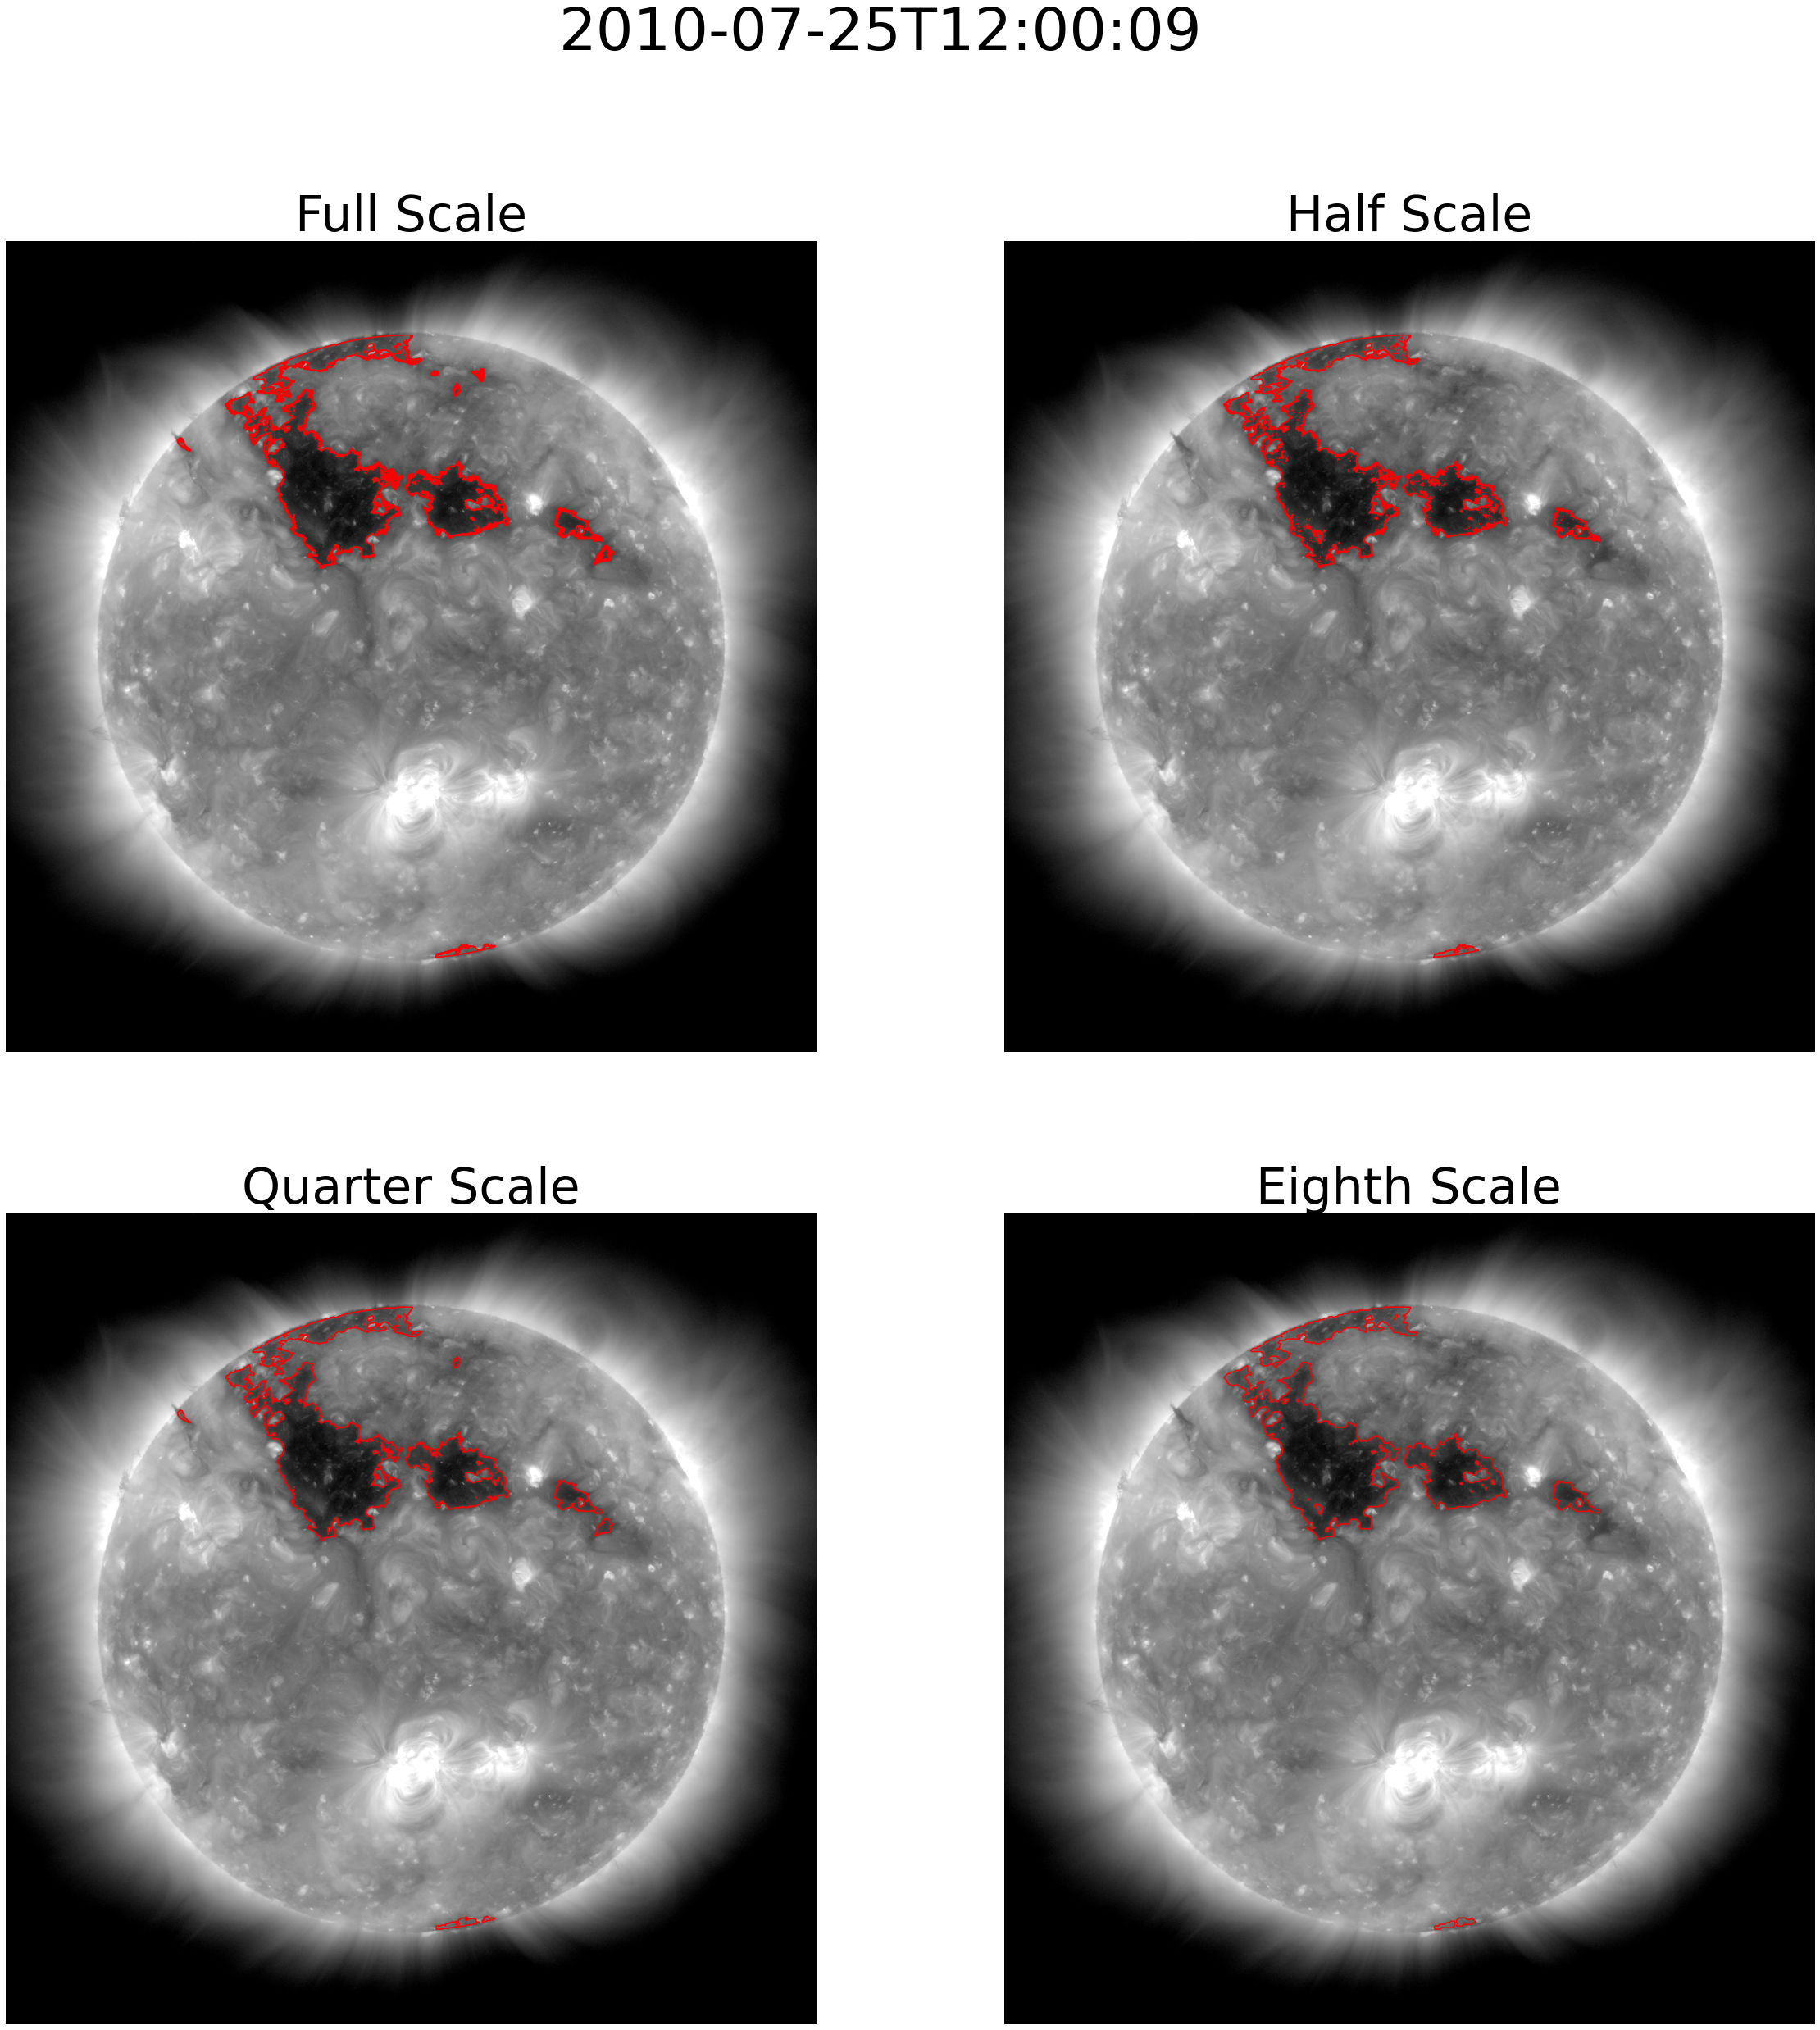

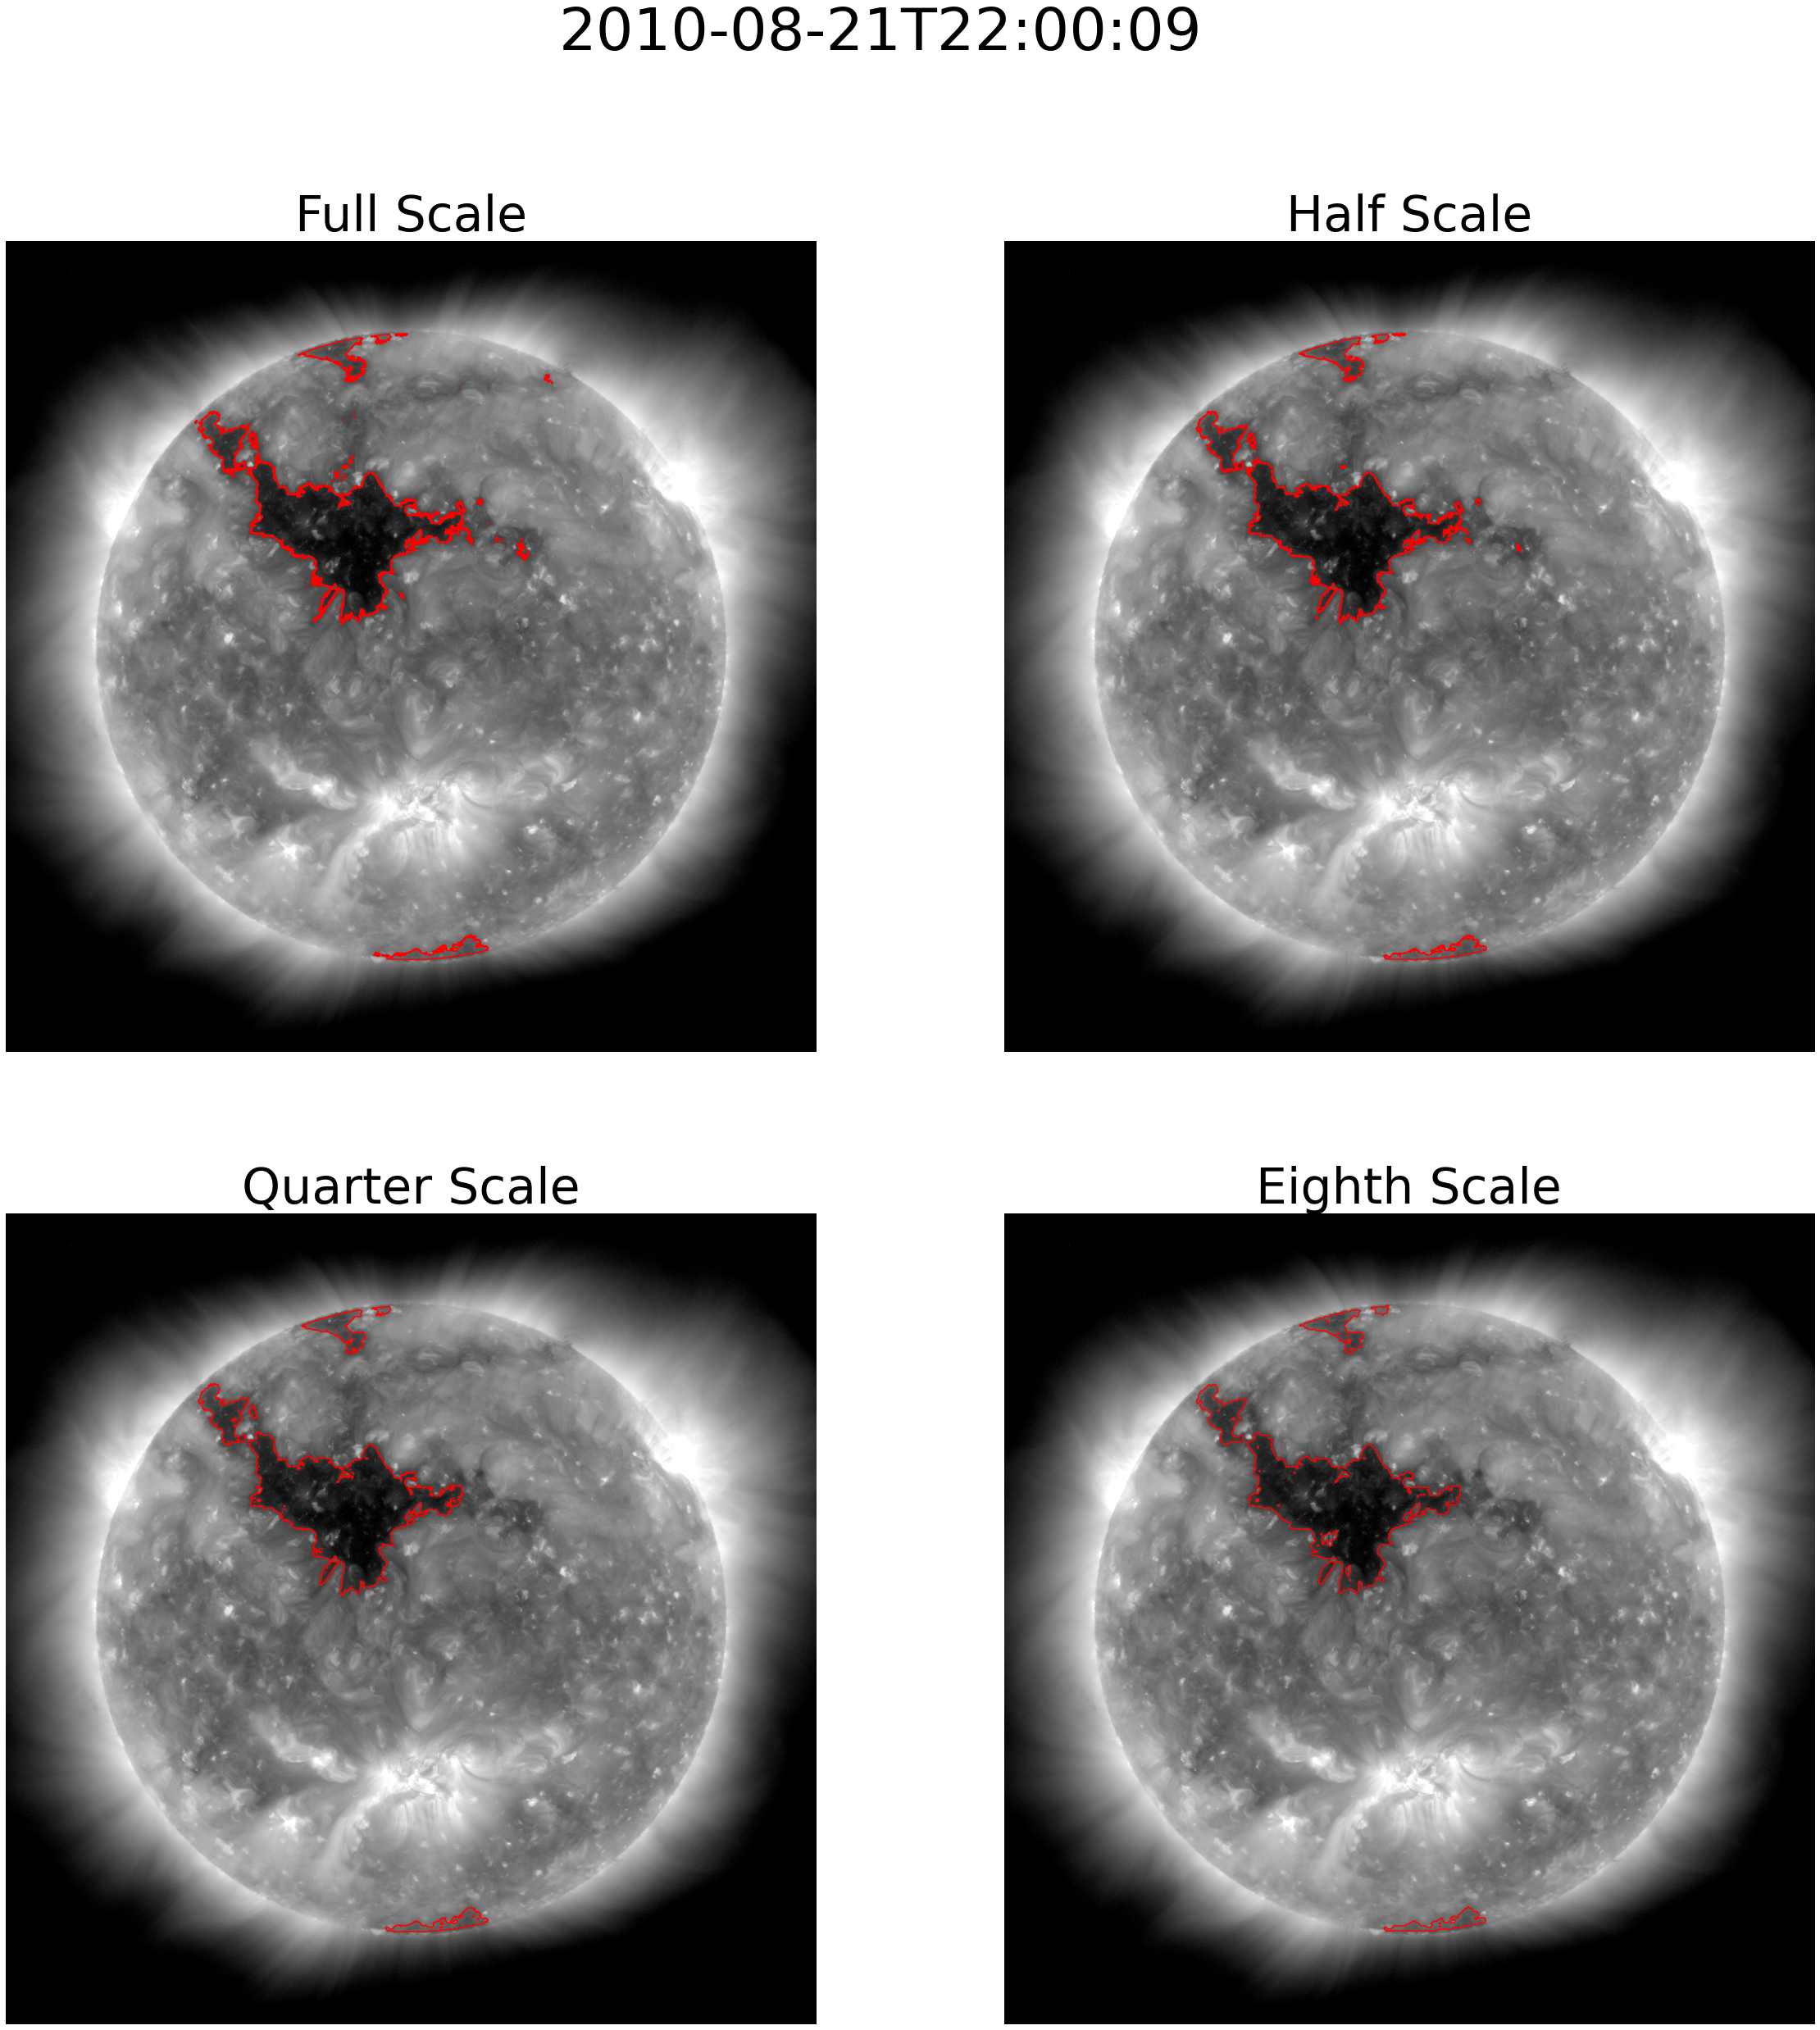

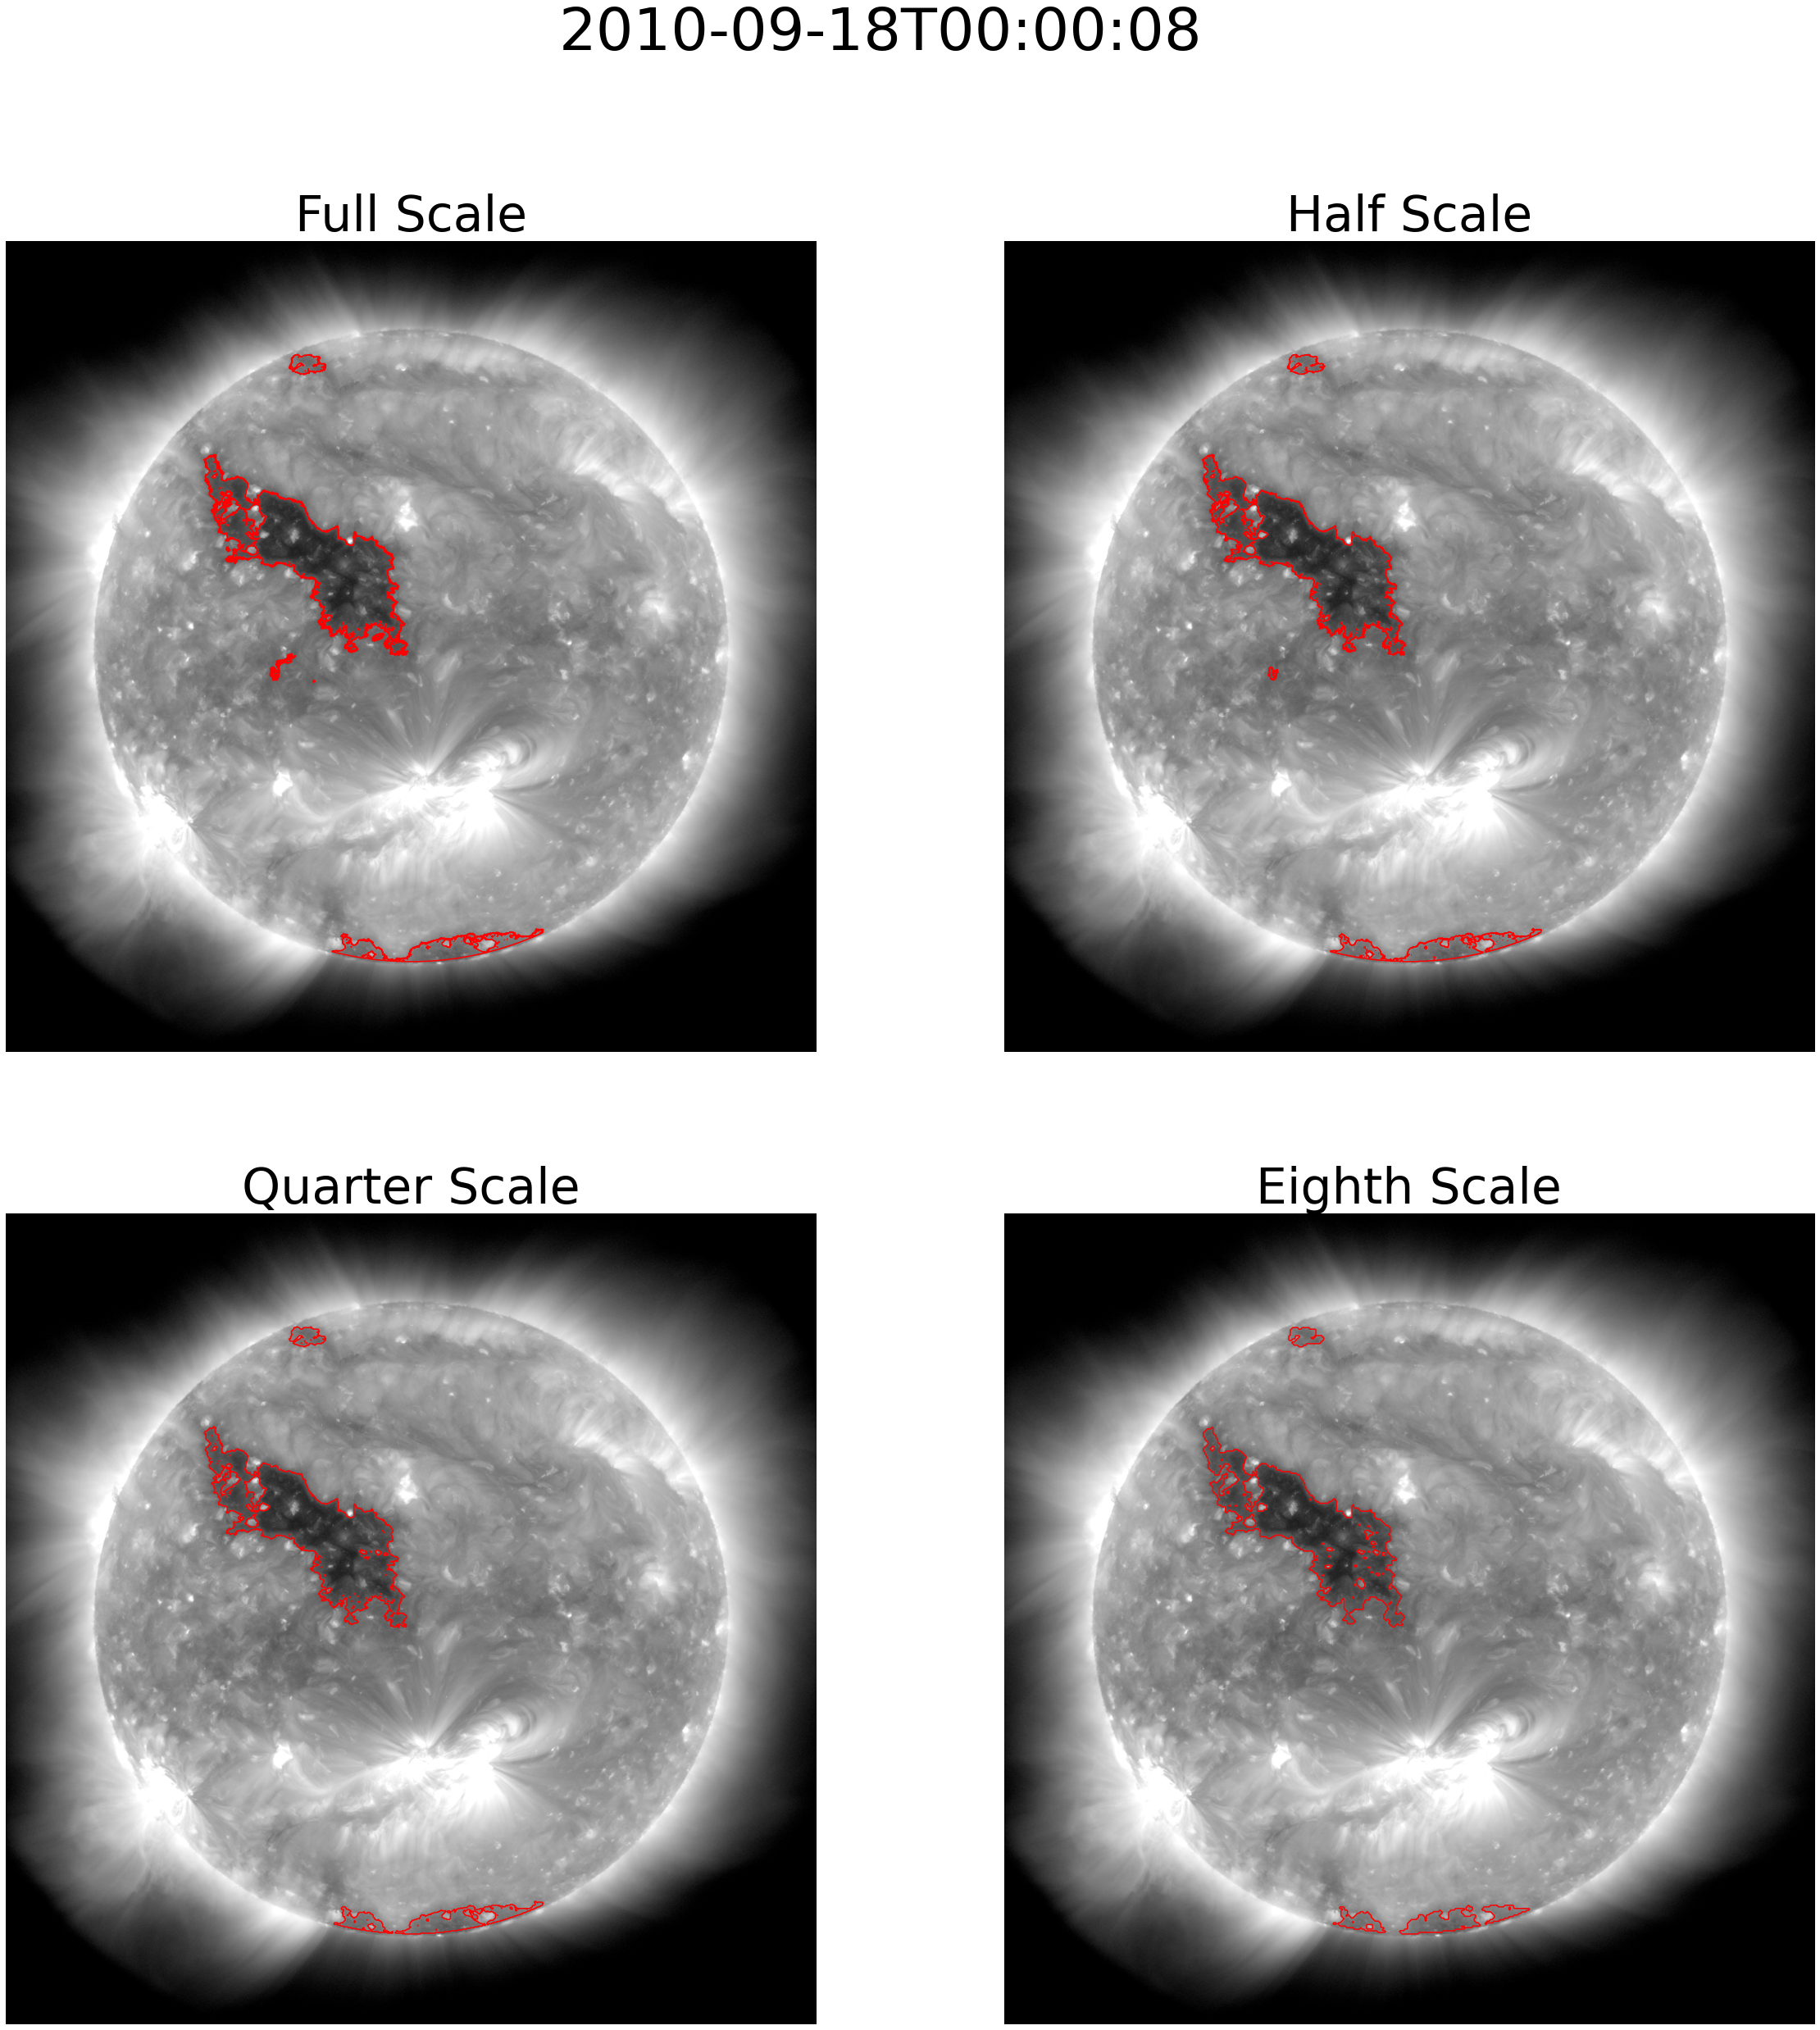

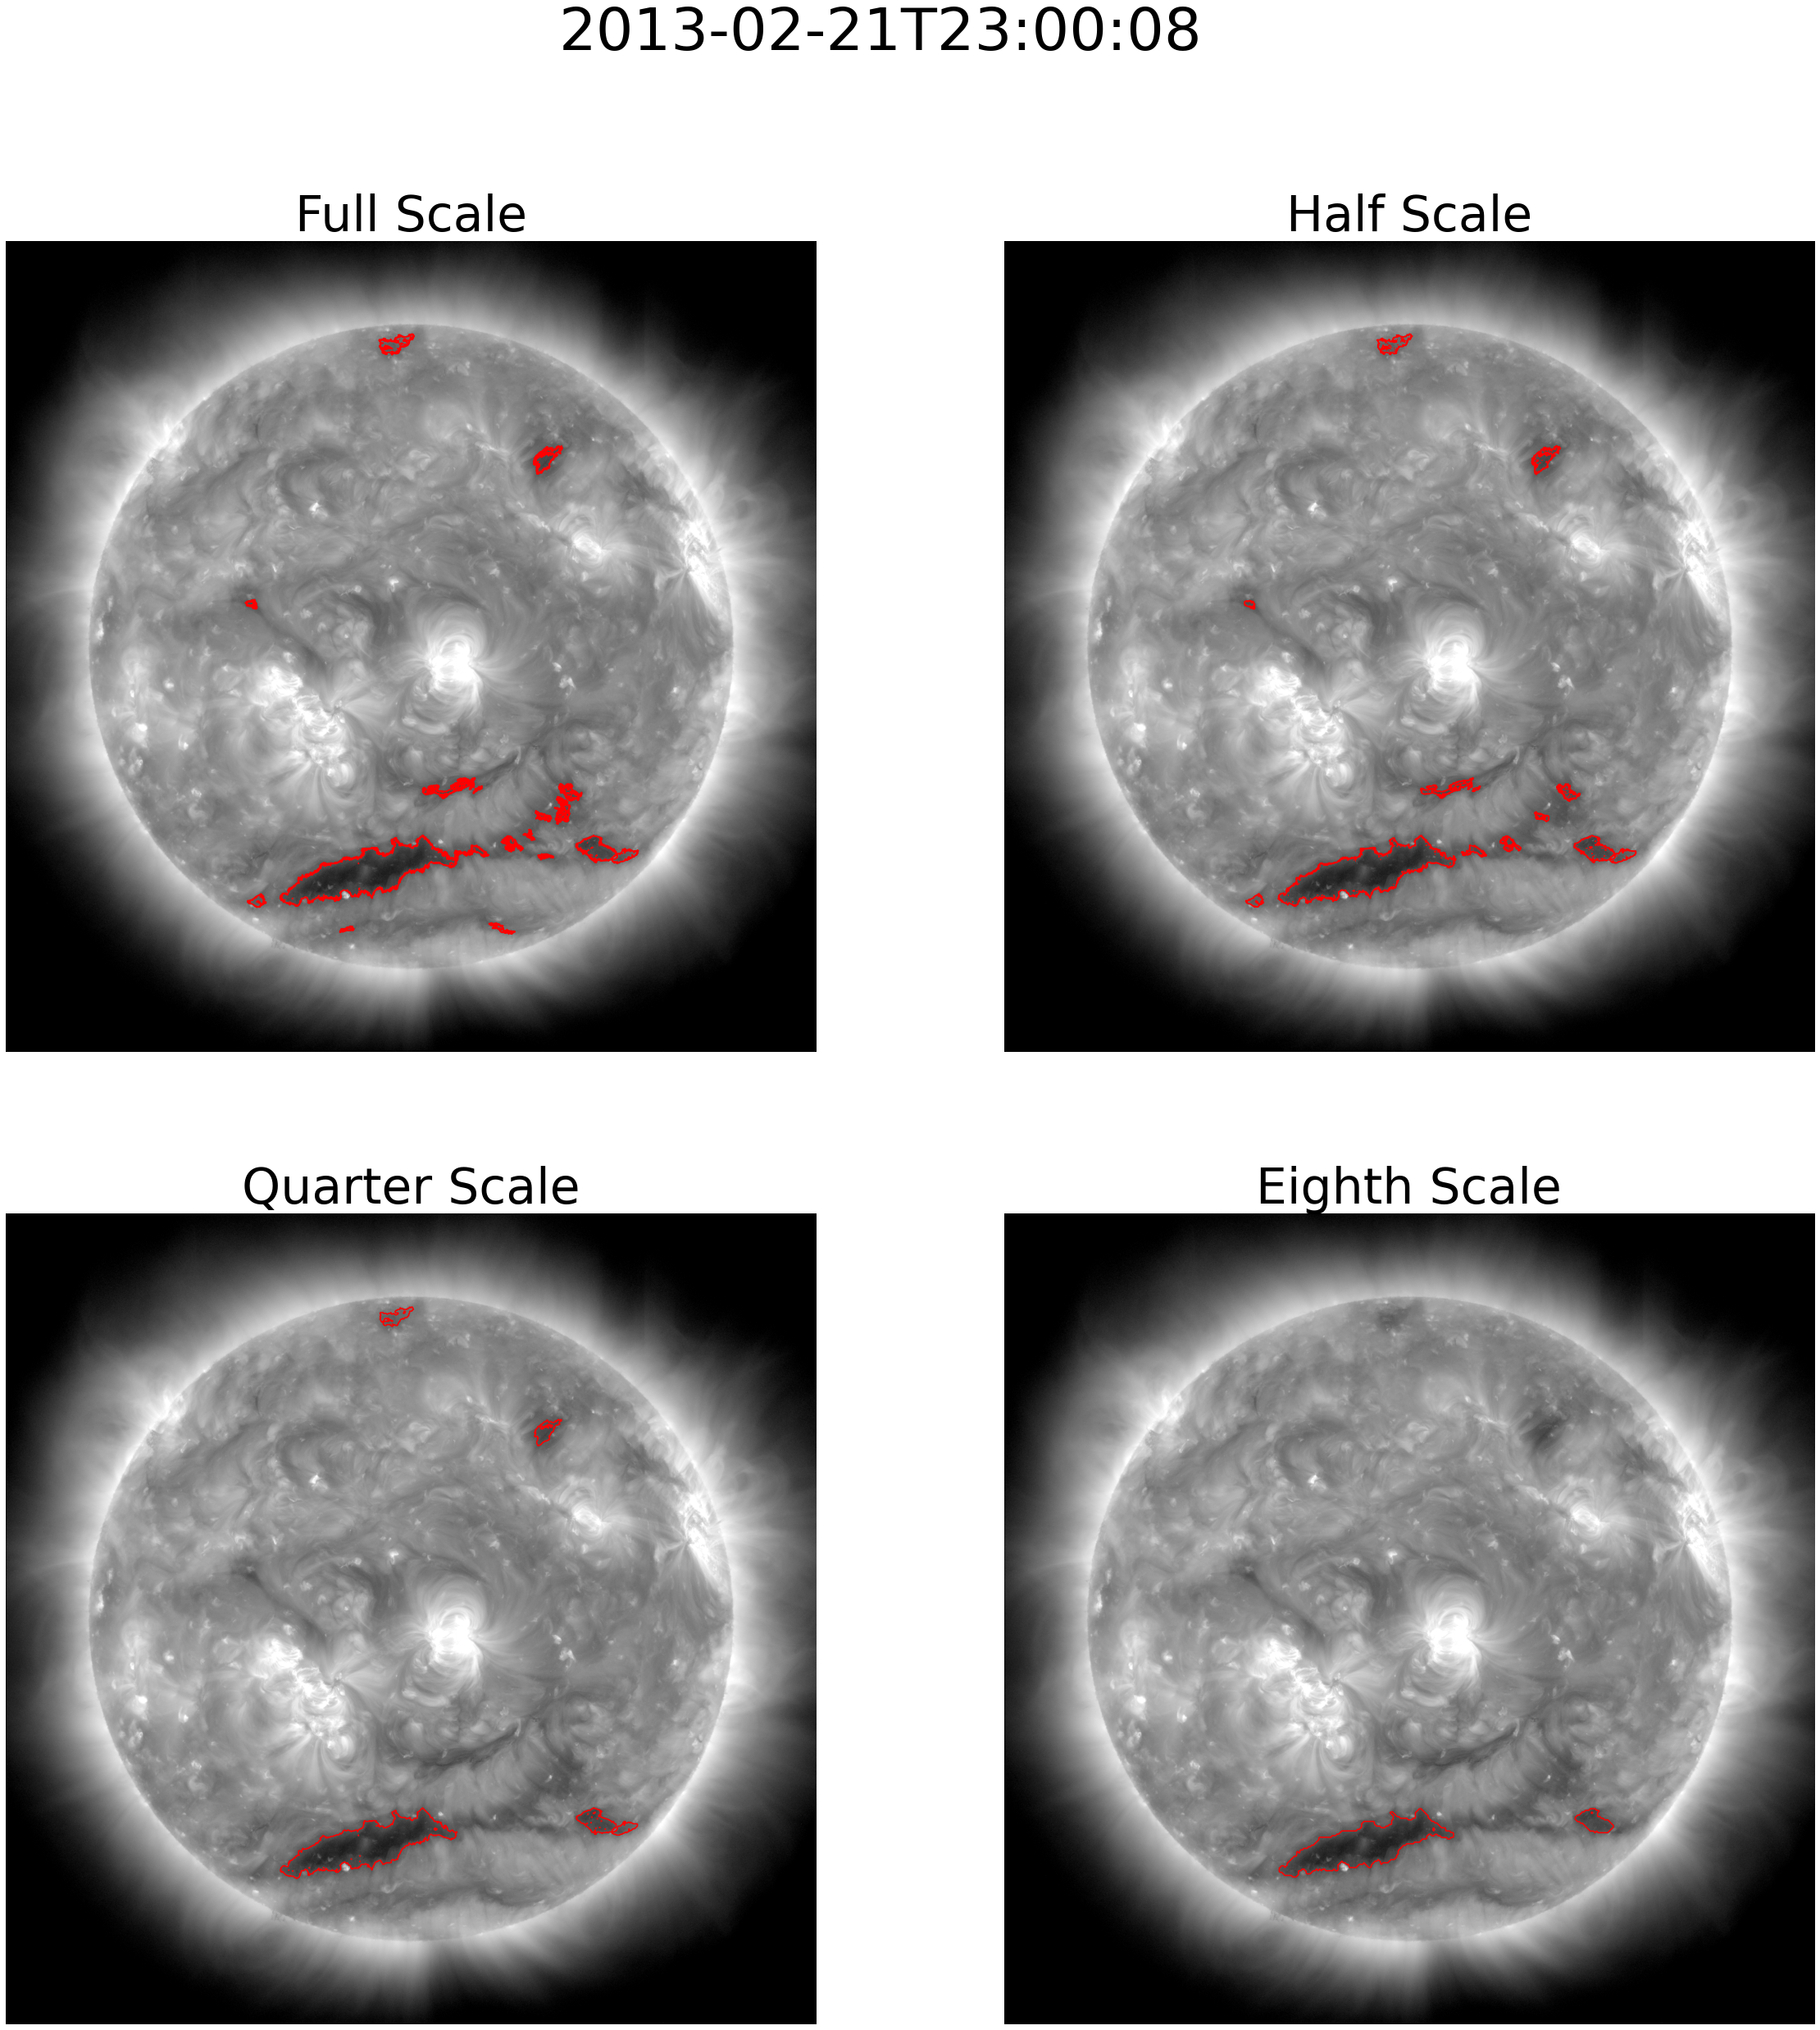

In [5]:
for ImageName in ImageNames:
    
    # Get File Names
    filename = dataset + ImageName
    ACWEfiles = ImageName.split('/')[0]+'/'+ImageName.split('/')[1]+'/'
    ACWEfiles = np.hstack([sorted(glob.glob(saveFolderScaled+ACWEfiles+'*'+os.path.basename(ImageName)+'*')),
                           glob.glob(saveFolderDefault+ACWEfiles+'*'+os.path.basename(ImageName)+'*')])
    
    # Get File Times
    time = dmt.timeFormat(dmt.timeFromFilenameAIA(ImageName))
    
    # Open AIA Image
    I,Idsp,H = openAIA(filename)
    
    # Open and save each mask
    plt.figure(figsize=[40,40])
    plt.rcParams.update({'font.size': 60})
    plt.suptitle(time)
    for i in range(len(ACWEfiles)):
        
        file = ACWEfiles[i]

        # Open File
        H,AH,SegC = acweSaveSeg_v4.openSeg(file)

        # Upscale
        segc = acweRestoreScale.upscale(SegC,AH)
        plt.subplot(2,2,i+1)
        plt.imshow(np.flip(Idsp,axis=0),cmap ='gray')
        plt.contour(np.flip(segc,axis=0),0,colors='r')
        plt.axis(False)
        
        # Title
        if i == 0:
            title = 'Full Scale'
        if i == 1:
            title = 'Half Scale'
        if i == 2:
            title = 'Quarter Scale'
        if i == 3:
            title = 'Eighth Scale'
        plt.rcParams.update({'font.size': 50})
        plt.title(title)
    
    # Save File
    file = saveDirectory + os.path.basename(ImageName) + '.tiff'
    plt.savefig(file)
    plt.show()